In [1]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

#Running the script with parameter definitions and functions:
%run populations_functions.py

K = 1; 0.5*dg/dt = 1250.0
D = 50.0; 0.5*dg**2/dt = 500.00000000000006


In [9]:
p_unreg,p_reg = selection(p0_unreg,p0_reg,sug,alpha,delta)

In [10]:
#Start with some sugar levels, which are uniformly distributed:
sugars_info = np.linspace(60,430,num=10)
p_sugars = np.ones_like(sugars_info)
p_sugars = p_sugars/np.sum(p_sugars)

#Now, some values of the expression noise alpha:
# alphas = np.logspace(np.log10(0.2),np.log10(5),2)
alphas = np.logspace(np.log10(0.5),np.log10(5),5)
deltas = np.logspace(-1,np.log10(25),num=6)

#Define the quantities we need. First, colony fitness:
col_fit_unreg_unsel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_reg_unsel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_unreg_sel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_reg_sel = np.zeros((len(alphas),len(deltas),len(sugars_info)))

#Fitness across all sugars:
tot_fit_unreg_unsel = np.zeros((len(alphas),len(deltas)))
tot_fit_reg_unsel = np.zeros((len(alphas),len(deltas)))
tot_fit_unreg_sel = np.zeros((len(alphas),len(deltas)))
tot_fit_reg_sel = np.zeros((len(alphas),len(deltas)))

#To compute mutual information, we use the formula I(g;s) = H(g) - H(g|s). For H(g), we need the marginal...
#...distributions for all four cases:
marg_unreg_unsel = np.zeros((len(alphas),len(deltas),len(g)))
marg_reg_unsel = np.zeros((len(alphas),len(deltas),len(g)))
marg_unreg_sel = np.zeros((len(alphas),len(deltas),len(g)))
marg_reg_sel = np.zeros((len(alphas),len(deltas),len(g)))

#Then we need the conditional entropies H(g|s). We'll calculate these inside the sugar loop:
condEnt_unreg_unsel = np.zeros((len(alphas),len(deltas)))
condEnt_reg_unsel = np.zeros((len(alphas),len(deltas)))
condEnt_unreg_sel = np.zeros((len(alphas),len(deltas)))
condEnt_reg_sel = np.zeros((len(alphas),len(deltas)))

#The marginal entropy H(g):
ent_unreg_unsel = np.zeros((len(alphas),len(deltas)))
ent_reg_unsel = np.zeros((len(alphas),len(deltas)))
ent_unreg_sel = np.zeros((len(alphas),len(deltas)))
ent_reg_sel = np.zeros((len(alphas),len(deltas)))

#Finally, MI as a function of noise:
MI_unreg_unsel = np.zeros((len(alphas),len(deltas)))
MI_reg_unsel = np.zeros((len(alphas),len(deltas)))
MI_unreg_sel = np.zeros((len(alphas),len(deltas)))
MI_reg_sel = np.zeros((len(alphas),len(deltas)))

In [31]:
for alpha_idx in range(len(alphas)):
    alpha = alphas[alpha_idx]
    for delta_idx in range(len(deltas)):
        delta = deltas[delta_idx]
        print(f"alpha={alpha}; delta={delta}\n")
        #Defining p0_unreg:
        g_peak = 0.5*(g_min+g_max)
#         p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
        p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1)).astype('float64')

        #Now looping over sugars:
        for sug_idx in range(len(sugars_info)):
            #Sugar, fitness function for this sugar and the optimal g:
            sug = sugars_info[sug_idx]
            fit = fitness(g,sug,delta)
            g_reg = g[np.argmax(fit)]
            #The fitness range:
            fit_range = np.max(fitness(g,sug,delta))-np.min(fitness(g,sug,delta))
            #Defining p0_reg
#             p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1))
            p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1)).astype('float64')
            p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

            #Calculating the normalized colony fitness (dividing by max possible fitness, f(g_reg,s)) already for p0_unreg and p0_reg:
            col_fit_unreg_unsel[alpha_idx][delta_idx][sug_idx] = (mean_wrt_P(fit,p0_unreg,g)-np.min(fitness(g,sug,delta)))/fit_range
            col_fit_reg_unsel[alpha_idx][delta_idx][sug_idx] = (mean_wrt_P(fit,p0_reg,g)-np.min(fitness(g,sug,delta)))/fit_range
            #Calculating the marginals for these above two cases:
            marg_unreg_unsel[alpha_idx][delta_idx] = marg_unreg_unsel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p0_unreg
            marg_reg_unsel[alpha_idx][delta_idx] = marg_reg_unsel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p0_reg
            #Now conditional entropies:
            dummy = np.clip(p0_unreg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_unreg_unsel[alpha_idx][delta_idx] = condEnt_unreg_unsel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))
            dummy = np.clip(p0_reg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_reg_unsel[alpha_idx][delta_idx] = condEnt_reg_unsel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))

            #Now running the solver, i.e. letting selection take its course:
            p_unreg,p_reg = selection(p0_unreg,p0_reg,sug,alpha,delta)

            #Colony fitness for p_unreg and p_reg:
            col_fit_unreg_sel[alpha_idx][delta_idx][sug_idx] = (mean_wrt_P(fit,p_unreg,g)-np.min(fitness(g,sug,delta)))/fit_range
            col_fit_reg_sel[alpha_idx][delta_idx][sug_idx] = (mean_wrt_P(fit,p_reg,g)-np.min(fitness(g,sug,delta)))/fit_range
            #Now their marginals:
            marg_unreg_sel[alpha_idx][delta_idx] = marg_unreg_sel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p_unreg
            marg_reg_sel[alpha_idx][delta_idx] = marg_reg_sel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p_reg        
            #The conditional entropy for p_unreg and p_reg, given by - P(s) sum_g P_reg(g|s) log2 P_reg(g|s):
            dummy = np.clip(p_unreg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_unreg_sel[alpha_idx][delta_idx] = condEnt_unreg_sel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))
            dummy = np.clip(p_reg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_reg_sel[alpha_idx][delta_idx] = condEnt_reg_sel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))

        #Ending the sugar loop. First we compute the total fitness across all sugars:
        tot_fit_unreg_unsel[alpha_idx][delta_idx] = np.sum(col_fit_unreg_unsel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_reg_unsel[alpha_idx][delta_idx] = np.sum(col_fit_reg_unsel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_unreg_sel[alpha_idx][delta_idx] = np.sum(col_fit_unreg_sel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_reg_sel[alpha_idx][delta_idx] = np.sum(col_fit_reg_sel[alpha_idx][delta_idx]*p_sugars)

        #Now calculating the marginal entropies and information:
        dummy = np.clip(marg_unreg_unsel[alpha_idx][delta_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_unreg_unsel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
        MI_unreg_unsel[alpha_idx][delta_idx] = ent_unreg_unsel[alpha_idx][delta_idx] - condEnt_unreg_unsel[alpha_idx][delta_idx]

        dummy = np.clip(marg_reg_unsel[alpha_idx][delta_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_reg_unsel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
        MI_reg_unsel[alpha_idx][delta_idx] = ent_reg_unsel[alpha_idx][delta_idx] - condEnt_reg_unsel[alpha_idx][delta_idx]

        dummy = np.clip(marg_unreg_sel[alpha_idx][delta_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_unreg_sel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
        MI_unreg_sel[alpha_idx][delta_idx] = ent_unreg_sel[alpha_idx][delta_idx] - condEnt_unreg_sel[alpha_idx][delta_idx]

        dummy = np.clip(marg_reg_sel[alpha_idx][delta_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_reg_sel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
        MI_reg_sel[alpha_idx][delta_idx] = ent_reg_sel[alpha_idx][delta_idx] - condEnt_reg_sel[alpha_idx][delta_idx]
        
#Writing to files:
np.savetxt("2a_fit_unreg_unsel.txt",tot_fit_unreg_unsel.flatten())
np.savetxt("2a_fit_reg_unsel.txt",tot_fit_reg_unsel.flatten())
np.savetxt("2a_fit_unreg_sel.txt",tot_fit_unreg_sel.flatten())
np.savetxt("2a_fit_reg_sel.txt",tot_fit_reg_sel.flatten())

np.savetxt("2a_MI_unreg_unsel.txt",MI_unreg_unsel.flatten())
np.savetxt("2a_MI_reg_unsel.txt",MI_reg_unsel.flatten())
np.savetxt("2a_MI_unreg_sel.txt",MI_unreg_sel.flatten())
np.savetxt("2a_MI_reg_sel.txt",MI_reg_sel.flatten())

alpha=0.5; delta=0.1

alpha=0.5; delta=0.30170881682725814

alpha=0.5; delta=0.9102821015130401

alpha=0.5; delta=2.746401358265295

alpha=0.5; delta=8.286135043349967

alpha=0.5; delta=25.000000000000007

alpha=0.8891397050194614; delta=0.1

alpha=0.8891397050194614; delta=0.30170881682725814

alpha=0.8891397050194614; delta=0.9102821015130401

alpha=0.8891397050194614; delta=2.746401358265295

alpha=0.8891397050194614; delta=8.286135043349967

alpha=0.8891397050194614; delta=25.000000000000007

alpha=1.5811388300841898; delta=0.1

alpha=1.5811388300841898; delta=0.30170881682725814

alpha=1.5811388300841898; delta=0.9102821015130401

alpha=1.5811388300841898; delta=2.746401358265295

alpha=1.5811388300841898; delta=8.286135043349967

alpha=1.5811388300841898; delta=25.000000000000007

alpha=2.8117066259517456; delta=0.1

alpha=2.8117066259517456; delta=0.30170881682725814

alpha=2.8117066259517456; delta=0.9102821015130401

alpha=2.8117066259517456; delta=2.746401358265295

alpha=2.8

In [11]:
#Reading from files:
tot_fit_unreg_unsel = np.loadtxt("2a_fit_unreg_unsel.txt").reshape(len(alphas),len(deltas))
tot_fit_reg_unsel = np.loadtxt("2a_fit_reg_unsel.txt").reshape(len(alphas),len(deltas))
tot_fit_unreg_sel = np.loadtxt("2a_fit_unreg_sel.txt").reshape(len(alphas),len(deltas))
tot_fit_reg_sel = np.loadtxt("2a_fit_reg_sel.txt").reshape(len(alphas),len(deltas))

MI_unreg_unsel = np.loadtxt("2a_MI_unreg_unsel.txt").reshape(len(alphas),len(deltas))
MI_reg_unsel = np.loadtxt("2a_MI_reg_unsel.txt").reshape(len(alphas),len(deltas))
MI_unreg_sel = np.loadtxt("2a_MI_unreg_sel.txt").reshape(len(alphas),len(deltas))
MI_reg_sel = np.loadtxt("2a_MI_reg_sel.txt").reshape(len(alphas),len(deltas))

In [12]:
MI_reg_sel

array([[4.63784367, 4.64560847, 4.66749525, 4.74507557, 4.96663569,
        5.36821906],
       [3.85531112, 3.87114109, 3.9218672 , 4.06772585, 4.39301737,
        4.87788633],
       [3.09720285, 3.15416243, 3.21530874, 3.44910645, 3.86414713,
        4.41246831],
       [2.3880262 , 2.43617332, 2.58024278, 2.89721122, 3.37662897,
        3.9680386 ],
       [1.83271341, 1.82398998, 2.03421994, 2.41042215, 2.92750266,
        3.54309488]])

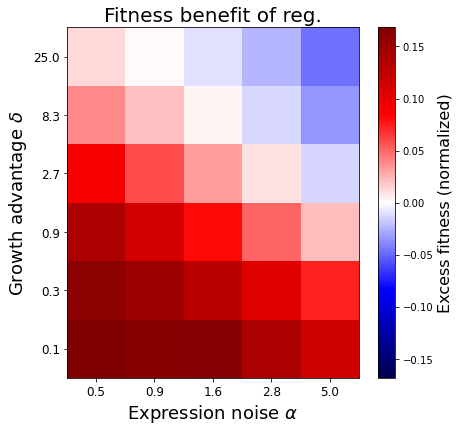

In [13]:
#Excess fitness given by regulation with precise sensing:
phase_diag = (tot_fit_reg_unsel-tot_fit_unreg_sel).T
cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
pic=ax.imshow(phase_diag,vmin=-cbar_lim,vmax=cbar_lim,cmap='seismic',aspect='equal',origin='lower')
cbar = plt.colorbar(pic)
cbar.set_label(r"Excess fitness (normalized)",fontsize=16)
plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Growth advantage $\delta$",fontsize=18)
ax.set_title(f"Fitness benefit of reg.",fontsize=20)
# fig.savefig("2a_fitness_phase_diagram.svg", format="svg")
fig.savefig("2a_fitness_phase_diagram.eps", format="eps")

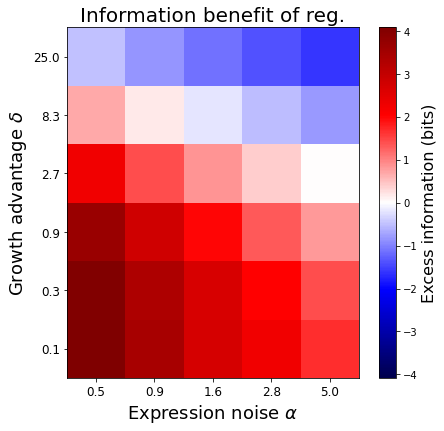

In [14]:
#Excess information given by regulation with precise sensing:
phase_diag = (MI_reg_unsel-MI_unreg_sel).T
cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
pic=ax.imshow(phase_diag,vmin=-cbar_lim,vmax=cbar_lim,cmap='seismic',aspect='equal',origin='lower')
cbar = plt.colorbar(pic)
cbar.set_label(r"Excess information (bits)",fontsize=16)
plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Growth advantage $\delta$",fontsize=18)
ax.set_title(f"Information benefit of reg.",fontsize=20)
# fig.savefig("2a_MI_phase_diagram.svg", format="svg")
fig.savefig("2a_MI_phase_diagram.eps", format="eps")

([<matplotlib.axis.YTick at 0x7f68c1870b50>,
 [Text(0, 0, '0.1'),
  Text(0, 1, '0.3'),
  Text(0, 2, '0.9'),
  Text(0, 3, '2.7'),
  Text(0, 4, '8.3'),
  Text(0, 5, '25.0')])

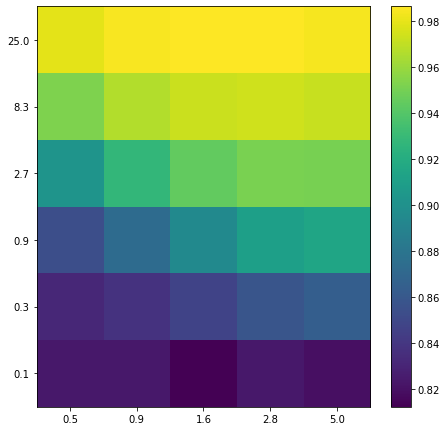

In [20]:
phase_diag = (tot_fit_unreg_sel).T
# cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
# pic=ax.imshow(phase_diag,vmin=-cbar_lim,vmax=cbar_lim,cmap='seismic',aspect='equal',origin='lower')
pic=ax.imshow(phase_diag,cmap='viridis',aspect='equal',origin='lower')
cbar = plt.colorbar(pic)
plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))

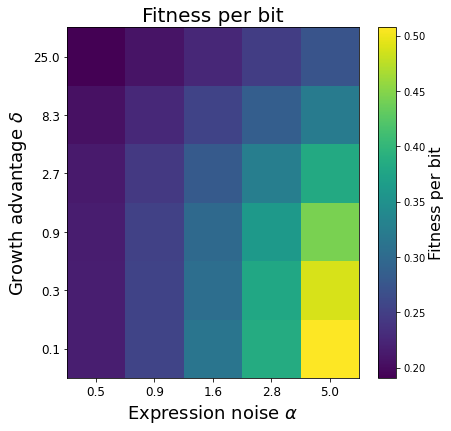

In [16]:
phase_diag = (tot_fit_reg_sel/MI_reg_sel).T
# cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
pic=ax.imshow(phase_diag,cmap='viridis',aspect='equal',origin='lower')
cbar = plt.colorbar(pic)
plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))
cbar.set_label(r"Fitness per bit",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Growth advantage $\delta$",fontsize=18)
ax.set_title(f"Fitness per bit",fontsize=20)
# fig.savefig("2a_fit_per_bit_phase_diagram.svg", format="svg")
fig.savefig("2a_fit_per_bit_phase_diagram.eps", format="eps")

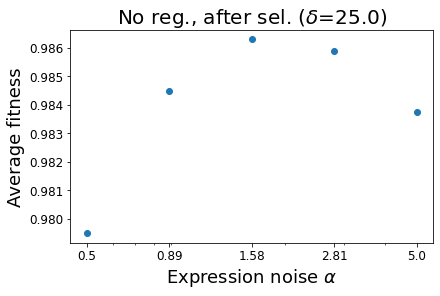

In [33]:
#x-ticks:
x_ticks = np.around(alphas,2)

#delta:
delta_idx = 5
delta = deltas[delta_idx]

fig,ax = plt.subplots(1,1,constrained_layout='true')
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.scatter(alphas,tot_fit_unreg_sel[:,delta_idx])
ax.set_xticks(alphas)
ax.set_xticklabels(np.around(alphas,2))
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Average fitness",fontsize=18)
ax.set_title(fr"No reg., after sel. ($\delta$={np.around(deltas[delta_idx],1)})",fontsize=20)
fig.savefig(f"2a_fit_unreg_sel_vs_alpha_delta={np.around(deltas[delta_idx],1)}.eps", format="eps")